# This source code is tested on Linux CentOS 7

# This source code reproduces the result of LEAF synthetic dataset training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.random as npr
from sklearn.metrics import accuracy_score
import json
npr.seed(1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_246676/3851912824.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Non-convex linear model with sigmoid loss
(see https://arxiv.org/pdf/1603.05643.pdf)

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def noncvx_sigmoidERM_loss(x, batch_features, targets):
    n_class = len(targets[0]) if len(targets.shape) > 1 else 1
    penalty = 1/(2*len(targets))
    if n_class > 1:
        x = x.reshape(n_class, -1)
    loss = np.mean(sigmoid(targets * (batch_features @ x.T)))
    loss += penalty * np.sum(np.linalg.norm(x, ord=2, axis=-1)**2)
    return loss


def noncvx_sigmoidERM_grad(x, batch_features, targets, weight_decay=1e-4):
    # n data, d dim, k class
    n_class = len(targets[0]) if len(targets.shape) > 1 else 1
    penalty = 1/2 * weight_decay
    if n_class <= 1:
        raise ValueError("unsupported atm")
    x = x.reshape(n_class, -1)
    sig_out = sigmoid(targets * (batch_features @ x.T)) # {n, k}
    grad = 1/len(targets) * (sig_out * (1-sig_out) * targets).T @ batch_features # numpy * operator is spreaded row-by-row
    grad += 2 * penalty * x
    return grad.flatten()


def noncvx_sigmoidERM_stochastic_grad(x, agent_features, agent_targets, it, batch_size, x_prev=None):
    batch_ind = npr.choice(len(agent_features), batch_size, replace=True) # draw ${batch_size} indices
    assert len(batch_ind) == batch_size, "Inconsistent with batch size {}, drawn {} instead".format(batch_size, len(batch_ind))
    if x_prev is None:
        return noncvx_sigmoidERM_grad(x, agent_features[batch_ind], agent_targets[batch_ind])
    else:
        return noncvx_sigmoidERM_grad(x, agent_features[batch_ind], agent_targets[batch_ind]), noncvx_sigmoidERM_grad(x_prev, agent_features[batch_ind], agent_targets[batch_ind])

def _noncvx_sigmoidERM_predict(x, feature, target):
    n_class = len(target[0]) if len(target.shape) > 1 else 1
    if n_class > 1:
        x = x.reshape(n_class, -1)
    acti = feature @ x.T # {n, k}
    if n_class > 1:
        preds = np.argmin(acti, axis=-1)
    else:
        preds = acti < 0
    return preds

def noncvx_sigmoidERM_acc(x, feature, target):
    n_class = len(target[0]) if len(target.shape) > 1 else 1
    preds = _noncvx_sigmoidERM_predict(x, feature, target)
    if n_class > 1:
        labels = np.argmax(target, axis=-1)
    else:
        labels = target > 0
    return accuracy_score(labels, preds)

def noncvx_sigmoidERM_unconsensal_count(X, feature, target):
    all_preds = np.array([_noncvx_sigmoidERM_predict(x, feature, target) for x in X])
    all_preds -= all_preds[0] # get difference with 1st agent prediction
    row_check = np.array(all_preds).T
    uncons_classify_count = feature.shape[0] - np.sum(np.all(row_check==0, axis=1))
    return uncons_classify_count

# Helper Functions

In [3]:
def top_k(x, k=1):
    dim = len(x)
    idx_sort = np.absolute(x).argsort()
    mask = np.ones(dim, dtype=x.dtype)
    mask[idx_sort[:dim-k]] = 0
    return x * mask


def top_k_mat(X, k=1):
    com_X = np.zeros(X.shape)
    for i in range(len(X)):
        com_X[i] = top_k(X[i], k)
    return com_X


def random_quantize_mat(X, s=4):
    # norm of vector: 32-bits
    # sign of vector entries: 1 * len(x) bits
    # s-bin interval: log(s+1) * len(x) bits
    # e.g. [0, .25, .5, .75, 1] as intervals, s=4
    # for x \in R^d: total = (32 + d * (1 + log(s+1))) bits     
    d = X.shape[1]
    tau = 1 + min([d/s**2, np.sqrt(d)/s])
    signs = np.sign(X)
    x_norms = np.linalg.norm(X, ord=2, axis=1).reshape(-1, 1)
    Q = np.abs(X)/x_norms * s + np.random.uniform(low=0, high=1, size=X.shape)
    Q = np.floor(Q) * signs * x_norms / (s * tau)
    return Q
    

def p_ring_graph(n_agents, p=1/3):
    # 2016 GT: p=1/4
    # 2021 Jiao: p=0.1
    graph = np.zeros((n_agents, n_agents))
    for i in range(n_agents):
        graph[i][i] = 1 - 2*p
        graph[i][(i-1)%n_agents] = p
        graph[i][(i+1)%n_agents] = p
    return graph


def noop(x, k=None):
    return x


def data_shuffle_index(ds):
    shuf_ind = np.array([], dtype=int)
    for i in range(len(ds)-1):
        offset = ds[i]
        bin_size = ds[i+1] - ds[i]
        ordering = npr.permutation(bin_size) + offset
        shuf_ind = np.append(shuf_ind, ordering)
    return shuf_ind


class DecenAlgo():
    def __init__(self, d, n_nodes, seed=1, x_init=1, lr_schedule=[1], lr_decay=2):
        self.lr_schedule = lr_schedule
        self.lr_decay = lr_decay
        self.worst_opt_gaps = []
        self.avg_opt_gaps = []
        self.opt_param_gaps = []
        self.grads = []
        self.worst_true_grads = []
        self.avg_true_grads = []
        self.net_use = []
        self.sample_use = []
        self.x_consensus_gap = []
        self.y_consensus_gap = []
        self.true_grad_norm = []
        self.comm_g_norm = []
        self.comm_x_norm = []
        self.global_loss = []
        self.global_acc = []
        self.global_test_loss = []
        self.global_test_acc = []
        self.cls_uncons = []
        self.cls_test_uncons = []
        self.diverge_count = 0
        # internal var. record
        self.X_hist = []
        self.X_hat_hist = []
        self.Y_hist = []
        self.Y_hat_hist = []
        self.shuf_hist = []
        # seeded init.
        npr.seed(seed)
        x = npr.uniform(-x_init, x_init, size=d)
        self.X = np.tile(x, (n_nodes, 1))
    
    def record(self, debug=False):
        def consensus_gap(X):
            avg_X = np.mean(X, axis=0)
            cons_gap = 0
            for x in X:
                cons_gap += np.linalg.norm(x - avg_X, ord=2)
            return cons_gap
    
        if debug:
            self.X_hist.append(self.X)
            self.X_hat_hist.append(self.X_hat)
            self.Y_hist.append(self.Y)
            self.Y_hat_hist.append(self.Y_hat)
        
        # record compressed comm. compensation
        if self.__class__ in [CHOCO_SGD, DoCoM]:
            self.comm_x_norm.append(np.linalg.norm(self.X_sent, ord="fro"))
            if self.__class__ == DoCoM:
                self.comm_g_norm.append(np.linalg.norm(self.Y_sent, ord="fro"))
        
        # record loss
        curr_losses = [loss_fct(x, features, targets) for x in self.X] # global loss
        if not test_features is None:
            curr_test_losses = [loss_fct(x, test_features, test_targets) for x in self.X] # global loss
            self.global_test_loss.append(curr_test_losses)
        self.global_loss.append(curr_losses)
        curr_loss_worst = np.max(curr_losses)
        curr_loss_gap = curr_loss_worst - opt_loss
        self.worst_opt_gaps.append(curr_loss_worst)
        avg_loss_gap = np.mean(curr_losses) - opt_loss
        self.avg_opt_gaps.append(avg_loss_gap)
    
        # record average accuracy
        accs = [acc_fct(param, features, targets) for param in self.X] # global acc
        self.global_acc.append(accs)
        if not test_features is None:
            test_accs = [acc_fct(param, test_features, test_targets) for param in self.X] # global acc
            self.global_test_acc.append(test_accs)
        avg_acc = np.mean(accs)
        
        if not x_opt is None:
            curr_opt_param_gap = [np.linalg.norm(x - x_opt, ord=2) for x in self.X]
            gap_avg = np.mean(curr_opt_param_gap)
            self.opt_param_gaps.append(gap_avg)

        self.grads.append(np.linalg.norm(self.Y, ord=2))

        self.x_consensus_gap.append(consensus_gap(self.X))    
        if self.__class__ in [GNSD, DeTAG, GT_HSGD, DoCoM, BEER]:
            self.y_consensus_gap.append(consensus_gap(self.Y))
        
        true_grads = [np.linalg.norm(grad_fct(x, features, targets), ord=2) for x in self.X]
        curr_worst_true_grad = max(true_grads)
        self.worst_true_grads.append(curr_worst_true_grad)
        self.avg_true_grads.append(np.mean(true_grads))
        
        self.cls_uncons.append(cons_fct(self.X, features, targets))
        if not test_features is None:
            self.cls_test_uncons.append(cons_fct(self.X, test_features, test_targets))
        
        self.net_use.append(self.net_unit)
        self.sample_use.append(self.sample_unit)
        if avg_acc > self.best_avg_acc:
            self.best_avg_acc = avg_acc
            self.best_acc_ItLoss = (self.it, curr_loss_gap)
            self.best_acc_ItGrad = (self.it, curr_worst_true_grad)
        # check divergence
        if curr_worst_true_grad > self.worst_true_grads[0] * 100:
            return True
        else:
            return False

    def curl_F(self, X, X_prev=None):
        if X_prev is None:
            curl = np.zeros(X.shape)
            for i in range(len(X)):
                curl[i] = stoc_grad_fct(X[i], self.features[i], self.targets[i], self.it, self.batch_size)
            return curl
        else:
            curl = np.zeros(X.shape)
            curl_prev = np.zeros(X.shape)
            for i in range(len(X)):
                curl[i], curl_prev[i] = stoc_grad_fct(X[i], self.features[i], self.targets[i], self.it, self.batch_size, x_prev=X_prev[i])
            return curl, curl_prev
    
    def local_full_curl_F(self, X):
        curl = np.zeros(X.shape)
        print("drawing local full gradient")
        for i in range(len(X)):
            curl[i] = grad_fct(X[i], self.features[i], self.targets[i])
        return curl
    
    def finish(self):
        self.net_use = np.cumsum(self.net_use)
        self.sample_use = np.cumsum(self.sample_use)
        
    def update_lr(self):
        if self.it in self.lr_schedule:
            self.lr /= self.lr_decay
            print("Current lr: {}".format(self.lr))
    
    def get_trunc_sample_dist(self, data_split):
        sample_dist = np.diff(data_split)
        sample_dist[sample_dist > self.batch_size] = self.batch_size
        return sample_dist


# SETUP
noncvx_sigmoidERM_funcs = (noncvx_sigmoidERM_loss, noncvx_sigmoidERM_grad, noncvx_sigmoidERM_stochastic_grad, noncvx_sigmoidERM_acc, noncvx_sigmoidERM_unconsensal_count)

loss_fct, grad_fct, stoc_grad_fct, acc_fct, cons_fct = noncvx_sigmoidERM_funcs

graph_fct = p_ring_graph

# Data Setup

## LEAF Synthetic Data Generation

In [4]:
! git clone https://github.com/TalwalkarLab/leaf
! eval "cd leaf/data/synthetic && python main.py -num-tasks 25 -num-classes 5 -num-dim 1000"
! eval "cd leaf/data/synthetic && sh ./preprocess.sh -s niid --sf 1.0 -k 5 -t sample --tf 0.6 --smplseed 1639016083 --spltseed 1639016114"
! mv leaf/data/synthetic/data/train/*.json ./leaf_synthetic_train.json
! mv leaf/data/synthetic/data/test/*.json ./leaf_synthetic_test.json

Cloning into 'leaf'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 782 (delta 1), reused 1 (delta 0), pack-reused 776
Receiving objects: 100% (782/782), 6.79 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (372/372), done.
Generating dataset
Done :D
------------------------------
sampling data
Using seed 1639016083
/home/cyyau/docom_sgt/aistats/leaf/data/synthetic/meta
- random seed written out to /home/cyyau/docom_sgt/aistats/leaf/data/synthetic/meta/sampling_seed.txt
writing data_niid_0.json
------------------------------
removing users with less than 5 samples
writing data_niid_0_keep_5.json
------------------------------
generating training and test sets
- random seed written out to /home/cyyau/docom_sgt/aistats/leaf/data/synthetic/meta/split_seed.txt
splitting data by sample
writing data_niid_0_keep_5_train_6.json
writing data_niid_0_keep_5_test_6.json
------------------------------

In [5]:
def make_neg_pos(y):
    zero_idx = np.where(y==0)[0]
    y[zero_idx] = -1
    return y

def make_one_hot(y, neg_pos_label):
    # transform to one hot
    n_class = len(set(y))
    
    if n_class == 2 and neg_pos_label:
        return make_neg_pos(y)
    
    one_hot = np.zeros((len(y), n_class))
    if neg_pos_label: # y \in {-1, 1}
        one_hot -= 1
    for i, c in enumerate(y):
        one_hot[i][c] = 1
    return one_hot

        
def leaf_synthetic(file_path, neg_pos_label=False):
    with open(file_path) as f:
        train_data = json.load(f)

    data = train_data["user_data"]
    n_agents = len(data.keys())
    ds = [len(data[k]["y"]) for k in data.keys()]
    ds.insert(0, 0)
    ds = list(np.cumsum(ds))
    X = []
    Y = []
    for k in data.keys():
        X += data[k]["x"]
        Y += data[k]["y"]
    X = np.array(X)
    Y = np.array(Y)
    
    X = np.concatenate((X, np.ones((len(X), 1))), axis=1) # bias term, off centering
    one_hot = make_one_hot(Y, neg_pos_label)
    
    n_class = len(set(Y))
    d = len(X[0])
    data_num = 0
    batch_size = 4
    return X, one_hot, n_agents, n_class, d, data_num, batch_size, ds


x_opt = None
leaf_train = "leaf_synthetic_train.json"
leaf_test = "leaf_synthetic_test.json"

data_fct = leaf_synthetic

features, targets, n_agents, n_class, data_d, data_num, batch_size, ds = data_fct(leaf_train, True) # for leaf synth.
test_features, test_targets, _, _, _, _, _, _ = data_fct(leaf_test, True) # for leaf synth.

opt_loss = 0
model_d = data_d * n_class if n_class > 2 else data_d
d = model_d
n = n_agents
print("There are %d nodes, each with %s data points, over %d dimension, %d classes, %d batch size"%(n, str(np.diff(ds)), d, n_class, batch_size))

There are 25 nodes, each with [ 91  14 470  51  79   6   5   4   3   6  25   9  19 403  84  51  38  24
   5   4   4  10   4  31   3] data points, over 5005 dimension, 5 classes, 4 batch size


# Stochastic Decentralized Algorithms

In [6]:
class DSGD(DecenAlgo):
    def __init__(self, n_nodes=10, d=20, data_num=10, x_init=1, data_split=None, def_batch_size=0, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.W = graph_fct(n_nodes)
        self.net_unit = len(np.where(self.W - np.eye(n_nodes) > 0)[0]) * d * 64
        self.batch_size = def_batch_size
        sample_dist_trunc = self.get_trunc_sample_dist(data_split)
        self.sample_unit = np.sum(sample_dist_trunc)
        self.best_avg_acc = 0
        
    def name(self):
        return self.__class__.__name__ + " \u03b7=" + str(self.lr) + " b_avg_acc=%.2f"%(self.best_avg_acc)
 
    def train(self, epoch, lr):
        self.lr = lr
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        for self.it in tqdm(range(epoch)):
            self.update_lr()
            self.Y = self.curl_F(self.X) # for record
            self.X = self.W @ self.X - self.lr * self.Y
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()
        return epoch

In [7]:
class GNSD(DecenAlgo): # GT stochastic nonconvex
    def __init__(self, n_nodes=10, d=20, data_num=10, x_init=1, data_split=None, def_batch_size=0, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.it = -1
        self.Y = np.zeros(self.X.shape)
        self.W = graph_fct(n_nodes)
        
        self.n_comm = len(np.where(self.W - np.eye(n_nodes) > 0)[0])
        
        self.batch_size = def_batch_size
        self.best_avg_acc = 0
        self.grad_unit = self.batch_size
        
        self.sample_dist_trunc = self.get_trunc_sample_dist(data_split)
        self.sample_unit = np.sum(self.sample_dist_trunc)

    def name(self):
        return self.__class__.__name__ + " \u03b7=" + str(self.lr) + " b_avg_acc=%.2f"%(self.best_avg_acc)
    
    def train(self, epoch, lr):
        self.lr = lr
        self.X = self.W @ self.X # x^1 update
        self.Y = self.curl_F(self.X) # y^1 update
        curr_grad = self.Y
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        self.net_unit = self.n_comm * d * 64
        self.record()
        self.net_unit = self.n_comm * d * 64 * 2 # prm gossip and grad tracker gossip
        for self.it in tqdm(range(epoch-1)):
            self.update_lr()
            self.X = self.W @ self.X - self.lr * self.Y
            prev_grad = curr_grad
            curr_grad = self.curl_F(self.X)
            self.Y = self.W @ self.Y + curr_grad - prev_grad
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()
        return epoch

In [8]:
class DeTAG(DecenAlgo): # larger batch size, accelerated gossip
    def __init__(self, n_nodes=10, d=20, data_num=10, x_init=1, data_split=None, def_batch_size=0, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.it = -1
        self.Y = np.zeros(self.X.shape)
        self.W = graph_fct(n_nodes)
        eigs = np.sort(np.linalg.eig(self.W)[0])
        self.lambd = max(np.abs(eigs[0]), np.abs(eigs[-2]))
        self.gossip_eta = (1-np.sqrt(1-self.lambd**2)) / (1+np.sqrt(1-self.lambd**2))
        self.gossip_rounds = int(1/2 * np.log(n_nodes) / np.sqrt(1-self.lambd))
        self.batch_size = def_batch_size
        self.best_avg_acc = 0

    def name(self):
        return self.__class__.__name__ + " \u03b7=" + str(self.lr) + " gos_R={} orc_B={} gos_\u03b7={}".format(self.gossip_rounds, self.oracle_budget, self.gossip_eta) + " b_avg_acc=%.2f"%(self.best_avg_acc)
    
    def accelerated_gossip(self, Z):
        # essentially is many round of gossips, with "momentum/memory?"
        Z_prev = Z
        eta = self.gossip_eta
        for _ in range(self.gossip_rounds):
            Z_new = (1+eta) * self.W @ Z - eta * Z_prev
            Z_prev = Z
            Z = Z_new
        return Z_new

    def train(self, epoch, lr, B, R, override_gossip_eta=None):
        self.lr = lr
        self.oracle_budget = B
        self.gossip_rounds = R
        self.batch_size = self.batch_size // B
        self.sample_dist_trunc = self.get_trunc_sample_dist(self.ds)
        curr_grad = self.Y
        if not override_gossip_eta is None:
            self.gossip_eta = override_gossip_eta
        self.net_unit = len(np.where(self.W - np.eye(self.W.shape[0]) > 0)[0]) * d * self.gossip_rounds * 64 * 2 # prm gossip and grad tracker gossip
        self.sample_unit = np.sum(self.sample_dist_trunc) * self.oracle_budget
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        for self.it in tqdm(range(epoch)):
            # the proposed order
            self.update_lr()
            prev_grad = curr_grad
            curr_grad = sum([self.curl_F(self.X) for _ in range(self.oracle_budget)])
            self.X = self.accelerated_gossip(self.X)
            self.X = self.X - self.lr * self.Y
            self.Y = self.accelerated_gossip(self.Y)
            self.Y = self.Y + curr_grad - prev_grad
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()
        return epoch

In [9]:
class GT_HSGD(DecenAlgo): # SARAH type var. reduction
    def __init__(self, n_nodes=10, d=20, data_num=10, k=1, x_init=1, data_split=None, def_batch_size=0, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.k = k
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.W = graph_fct(n_nodes)
        self.X_p = np.zeros(self.X.shape)
        self.V = np.zeros(self.X.shape)
        self.V_p = np.zeros(self.X.shape)
        self.Y = np.zeros(self.X.shape)
        self.conn = np.where(self.W > 0)
        self.net_unit = len(np.where(self.W - np.eye(n_nodes) > 0)[0]) * d * 64 * 2 # prm gossip and grad tracker gossip
        self.batch_size = def_batch_size // 2
        self.best_avg_acc = 0
        
        self.sample_dist_trunc = self.get_trunc_sample_dist(data_split)
        self.sample_unit = data_split[-1] # full gradient
        
    def name(self):
        accs = [acc_fct(param, features, targets) for param in self.X]
        avg_acc = np.mean(accs)
        return self.__class__.__name__ + " \u03b7=" + str(self.lr) + " \u03b2=" + str(self.beta) + " b_avg_acc=%.2f"%(self.best_avg_acc)
 
    def train(self, epoch, lr, beta):
        self.lr = lr
        self.beta = beta
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        for self.it in tqdm(range(epoch)):
            self.update_lr()
            self.V_p = self.V
            if self.it == 0:
                self.V = self.local_full_curl_F(self.X) # b_0 = m
            else:
                new_grad, p_grad = self.curl_F(self.X, X_prev=self.X_p)
                self.V = new_grad + (1-self.beta) * (self.V - p_grad)
                self.sample_unit = np.sum(self.sample_dist_trunc) * 2
            
            self.Y = self.W @ (self.Y + self.V - self.V_p)
            self.X_p = self.X
            self.X = self.W @ (self.X - self.lr * self.Y)
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()

# Compressed Algorithms

In [10]:
class CHOCO_SGD(DecenAlgo): 
    def __init__(self, compress_fct, n_nodes=10, d=20, data_num=10, k=0, x_init=1, data_split=None, def_batch_size=0, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.k = k
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.X_hat = np.zeros((n_nodes, n_nodes, d)) # x_hat_{i,j}, on agent i of agent j / agent i recv from agent j
        self.W = graph_fct(n_nodes)
        self.Q = np.zeros(self.X.shape)
        self.X_sent = np.zeros(self.X.shape)
        self.conn = np.where(self.W > 0)
        
        self.compress = compress_fct
        
        n_conn = len(np.where(self.W - np.eye(n_nodes) > 0)[0])
        if compress_fct == top_k_mat or compress_fct == top_k:
            self.net_unit = n_conn * k * (32 + 64) # 32 bits indices (int) and 64 bits values (float)
        elif compress_fct == random_quantize_mat:
            # k is s
            self.net_unit = n_conn * (64 + d * (1 + np.log2(k+1)))
        elif compress_fct == TernGrad_mat:
            self.net_unit = n_conn * (64 + 2 * d)
        
        self.batch_size = def_batch_size
        self.best_avg_acc = 0
        self.sample_dist_trunc = self.get_trunc_sample_dist(self.ds)
        self.sample_unit = np.sum(self.sample_dist_trunc)
        
    def name(self):
        accs = [acc_fct(param, features, targets) for param in self.X]
        avg_acc = np.mean(accs)
        return "{}+{}".format(self.__class__.__name__, self.compress.__name__) + " \u03b7=" + str(self.lr) + " \u03b3=" + str(self.gamma) + " k=" + str(self.k) + " b_avg_acc=%.2f"%(self.best_avg_acc)
 
    def comm(self):
        for i in range(len(self.Q)):
            self.X_sent[i] = self.X[i] - self.X_hat[i][i]
        self.Q = self.compress(self.X_sent, self.k)
#         print("error_norm: {}".format(np.linalg.norm(self.Q - self.X_sent, ord=2)))
        for recver, sender in zip(*self.conn):
            self.X_hat[recver][sender] = self.X_hat[recver][sender] + self.Q[sender]
    
    def train(self, epoch, lr, gamma=0.5):
        self.lr = lr
        self.gamma = gamma
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        for self.it in tqdm(range(epoch)):
            self.update_lr()
            self.Y = self.curl_F(self.X)
            self.X = self.X - self.lr * self.Y # X_half
            self.X_half = self.X # for record
            self.X_hat_rec = self.X_hat
            self.comm()
            X_tmp = np.zeros(self.X.shape)
            for recver, sender in zip(*self.conn):
                X_tmp[recver] += self.W[recver][sender] * (self.X_hat[recver][sender] - self.X_hat[recver][recver])
            self.X = self.X + gamma * X_tmp
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()
        return epoch

In [11]:
class DoCoM(DecenAlgo): 
    def __init__(self, compress_fct, n_nodes, d, data_num, k=0, x_init=1, def_batch_size=0, data_split=None, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.k = k
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.W = graph_fct(n_nodes)
        self.I = np.eye(n_nodes)
        self.X_p = np.zeros(self.X.shape)
        self.it = 0
        self.batch_size = def_batch_size // 2
#         print("Initialize gt with stochastic gradient")
#         self.V = self.curl_F(self.X) # b_0 = 1
        self.V = self.local_full_curl_F(self.X) # b_0 = m
        self.V_p = np.zeros(self.X.shape)
        self.Y = self.V
        self.X_hat = np.zeros(self.X.shape)
        self.Y_hat = np.zeros(self.X.shape)
        self.X_sent = np.zeros(self.X.shape)
        self.Y_sent = np.zeros(self.X.shape)
        self.conn = np.where(self.W > 0)
        
        self.compress = compress_fct
        
        n_conn = len(np.where(self.W - np.eye(n_nodes) > 0)[0]) * 2 # *2 for theta and gt
        if compress_fct == top_k_mat or compress_fct == top_k:
            self.net_unit = n_conn * k * (32 + 64)  # 32 bits indices (int) and 64 bits values (float)
        elif compress_fct == random_quantize_mat:
            # k is s
            self.net_unit = n_conn * (64 + d * (1 + np.log2(k+1)))
        elif compress_fct == TernGrad_mat:
            self.net_unit = n_conn * (64 + 2 * d)
        self.best_avg_acc = 0
        
        self.sample_dist_trunc = self.get_trunc_sample_dist(data_split)
        
        
    def name(self):
        accs = [acc_fct(param, features, targets) for param in self.X]
        avg_acc = np.mean(accs)
        return "{}+{}".format(self.__class__.__name__, self.compress.__name__) + " \u03b7=" + str(self.lr) + " \u03b3=" + str(self.gamma) + " \u03b2=" + str(self.beta) + " k=" + str(self.k) + " b_avg_acc=%.2f"%(self.best_avg_acc)
 
    def train(self, epoch, lr, beta, gamma):
        self.lr = lr
        self.beta = beta
        self.gamma = gamma
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        for self.it in tqdm(range(epoch)):
            self.update_lr()
            if self.it == 0:
                self.sample_unit = self.ds[-1] # full gradient
                self.X_p = self.X
                self.X_sent = self.X - self.lr * self.Y - self.X_hat
                self.X_hat = self.X_hat + self.compress(self.X_sent, self.k) # error compensation
                self.X = self.X - self.lr * self.Y + self.gamma * (self.W - self.I) @ self.X_hat
            else:
                self.sample_unit = np.sum(self.sample_dist_trunc) * 2
                new_grad, p_grad = self.curl_F(self.X, X_prev=self.X_p)
                self.V_p = self.V
                self.V = new_grad + (1-self.beta) * (self.V - p_grad)
                self.Y_sent = self.Y + self.V - self.V_p - self.Y_hat
                self.Y_hat = self.Y_hat + self.compress(self.Y_sent, self.k) # error compensation
                self.Y = self.Y + self.V - self.V_p + self.gamma * (self.W - self.I) @ self.Y_hat

                self.X_p = self.X
                self.X_sent = self.X - self.lr * self.Y - self.X_hat
                self.X_hat = self.X_hat + self.compress(self.X_sent, self.k) # error compensation
                self.X = self.X - self.lr * self.Y + self.gamma * (self.W - self.I) @ self.X_hat

                self.grad_unit = batch_size*2
            stop = self.record()
            if stop:
                epoch = self.it
                break
        self.finish()

In [12]:
class BEER(DecenAlgo):
    def __init__(self, compress_fct, n_nodes, d, data_num, k=0, x_init=1, def_batch_size=0, data_split=None, seed=1):
        super().__init__(d, n_nodes, seed=seed, x_init=x_init)
        self.features = [features[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.targets = [targets[data_split[i]:data_split[i+1]] for i in range(n_nodes)]
        self.k = k
        self.ds = [i * (data_num // n_nodes) for i in range(n_nodes + 1)] if data_split is None else data_split
        self.W = graph_fct(n_nodes)
        self.I = np.eye(n_nodes)
        self.X_p = np.zeros(self.X.shape)
        self.it = 0
        self.batch_size = def_batch_size // 2
#         self.V = self.local_full_curl_F(self.X) # b_0 = m
        self.V = self.curl_F(self.X) # b_0 = batch size
        self.V_p = np.zeros(self.X.shape)
        self.H = np.zeros(self.X.shape) # X_hat
        self.G = np.zeros(self.X.shape) # Y_hat / V_hat here
        self.conn = np.where(self.W > 0)
        self.Grad = self.V
        self.Grad_p = np.zeros(self.X.shape)
        
        self.compress = compress_fct
        self.sample_dist_trunc = self.get_trunc_sample_dist(self.ds)
        self.sample_unit = np.sum(self.sample_dist_trunc)
        
        n_conn = len(np.where(self.W - np.eye(n_nodes) > 0)[0]) * 2 # *2 for theta and gt
        if compress_fct == top_k_mat or compress_fct == top_k:
            self.net_unit = n_conn * k * (32 + 64)  # 32 bits indices (int) and 64 bits values (float)
        elif compress_fct == random_quantize_mat:
            # k is s
            self.net_unit = n_conn * (64 + d * (1 + np.log2(k+1)))
        elif compress_fct == TernGrad_mat:
            self.net_unit = n_conn * (64 + 2 * d)
        self.best_avg_acc = 0
        
    def name(self):
        accs = [acc_fct(param, features, targets) for param in self.X]
        avg_acc = np.mean(accs)
        return "{}+{}".format(self.__class__.__name__, self.compress.__name__) + " \u03b7=" + str(self.lr) + " \u03b3=" + str(self.gamma) + " k=" + str(self.k) + " b_avg_acc=%.2f"%(self.best_avg_acc)
 
    def train(self, epoch, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.lr_schedule = [int(sch * epoch) for sch in self.lr_schedule]
        tqdm_iter = tqdm(range(epoch))
        for self.it in tqdm_iter:
            self.update_lr()
            
            self.X_p = self.X
            self.X = self.X - self.lr * self.V + self.gamma * (self.W - self.I) @ self.H  
            X_msg = self.X - self.H
            self.H = self.H + self.compress(X_msg, self.k) # error compensation
            
            self.grad_unit = self.ds[-1]
            
            self.Grad_p = self.Grad 
            self.Grad = self.curl_F(self.X)
            self.V = self.V + self.gamma * (self.W - self.I) @ self.G + self.Grad - self.Grad_p
            G_msg = self.V - self.G
            self.G = self.G + self.compress(G_msg, self.k) # error compensation
            
            self.Y = self.V
            stop = self.record()
            tqdm_iter.set_description("train_err: {:.3e}".format(self.worst_opt_gaps[-1]))
            if stop:
                epoch = self.it
                break
        self.finish()

# Train


In [13]:
iterations = 10000
x_init = np.sqrt(1/len(features[0]))
current_seed = 1

algos = []

algo_dsgd = DSGD(n_nodes=n, d=d, data_num=data_num, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed)
algo_dsgd.train(iterations, lr=0.01)
algos.append(algo_dsgd)

algo_gnsd = GNSD(n_nodes=n, d=d, data_num=data_num, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed) # GT in stochastic nonconvex
algo_gnsd.train(iterations, lr=0.005)
algos.append(algo_gnsd)

algo_detag = DeTAG(n_nodes=n, d=d, data_num=data_num, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed)
algo_detag.train(iterations, lr=0.005, B=1, R=1, override_gossip_eta=0)
algos.append(algo_detag)

algo_gt_hsgd = GT_HSGD(n_nodes=n, d=d, data_num=data_num, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed)
algo_gt_hsgd.train(iterations, lr=0.01, beta=0.01)
algos.append(algo_gt_hsgd)

algo_choco = CHOCO_SGD(top_k_mat, n_nodes=n, d=d, data_num=data_num, k=int(d*0.1), x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed) # compression in stochastic
algo_choco.train(iterations, lr=0.01, gamma=0.5)
algos.append(algo_choco)

algo_choco = CHOCO_SGD(random_quantize_mat, n_nodes=n, d=d, data_num=data_num, k=255, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed) # compression in stochastic
algo_choco.train(iterations, lr=0.01, gamma=0.9)
algos.append(algo_choco)

algo_docom = DoCoM(top_k_mat, n_nodes=n, d=d, data_num=data_num, k=int(d*0.05), x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed)
algo_docom.train(iterations, lr=0.01, beta=0.01, gamma=0.2)
algos.append(algo_docom)

algo_docom = DoCoM(random_quantize_mat, n_nodes=n, d=d, data_num=data_num, k=15, x_init=x_init, data_split=ds, def_batch_size=batch_size, seed=current_seed)
algo_docom.train(iterations, lr=0.01, beta=0.01, gamma=0.6)
algos.append(algo_docom)

algo_beer = BEER(top_k_mat, n_nodes=n, d=d, data_num=data_num, k=int(d*0.05), x_init=x_init, data_split=ds, def_batch_size=200, seed=current_seed)
algo_beer.train(iterations, lr=0.01, gamma=0.16)
algos.append(algo_beer)

algo_beer = BEER(random_quantize_mat, n_nodes=n, d=d, data_num=data_num, k=15, x_init=x_init, data_split=ds, def_batch_size=200, seed=current_seed)
algo_beer.train(iterations, lr=0.01, gamma=0.5)
algos.append(algo_beer)


  0%|                                                                                                                                                                                                     | 3/10000 [00:00<06:46, 24.59it/s]

drawing local full gradient


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:10<00:00, 23.25it/s]


drawing local full gradient


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:36<00:00, 15.70it/s]


drawing local full gradient


train_err: 3.708e-02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:14<00:00, 18.04it/s]


# Visualize Results

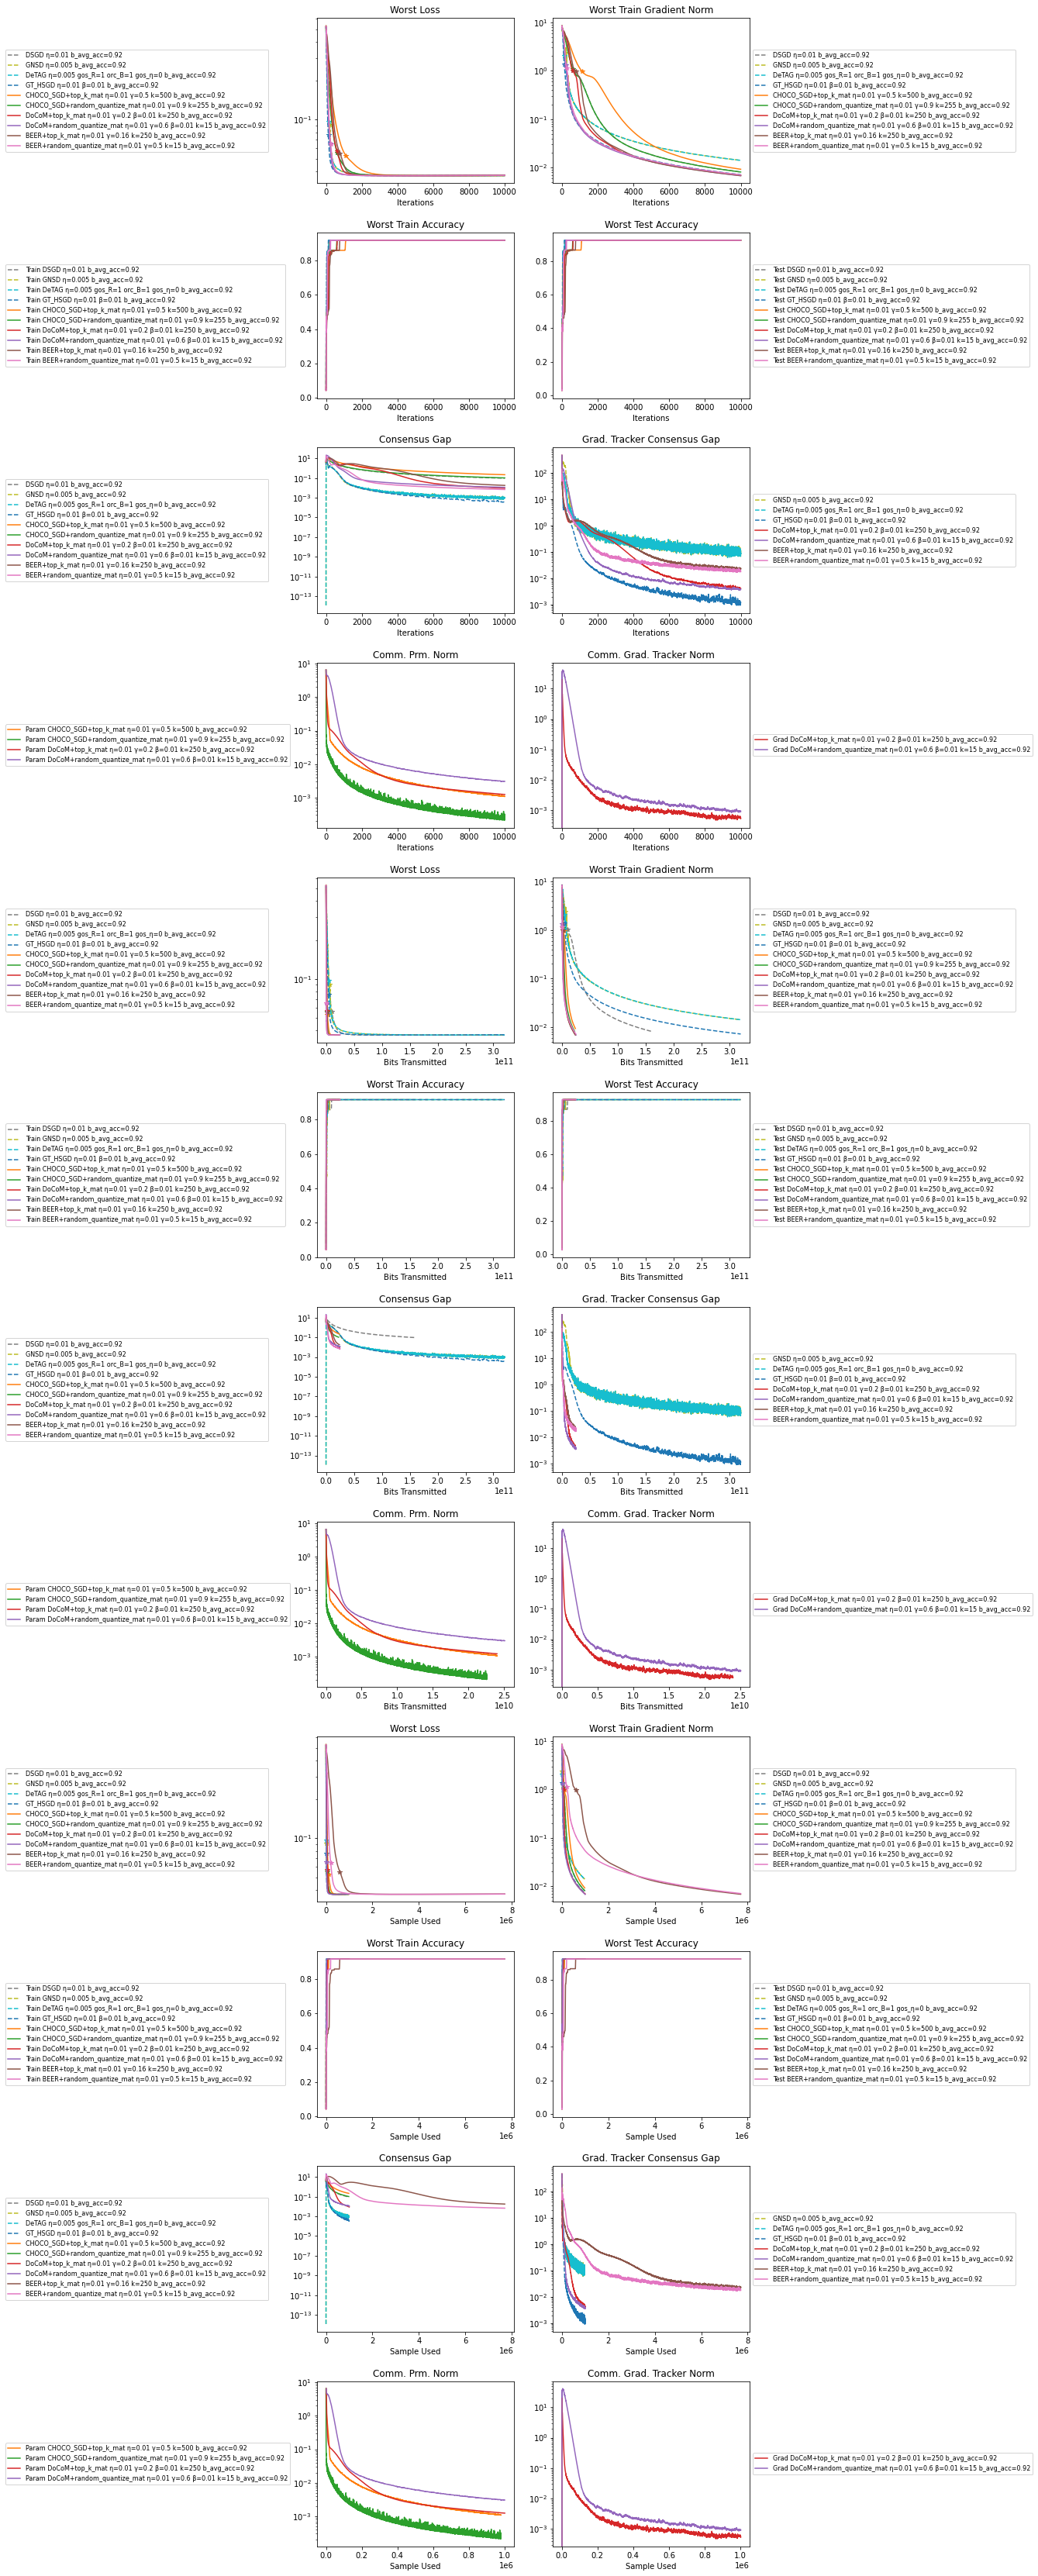

In [14]:
def plot_result(algos, fn=None):
    %matplotlib inline
    fig, axs = plt.subplots(12,2, figsize=(10,60))
    diagram_1, diagram_2, diagram_3 = [], [], []
    for i in range(4):
        for j in [0,1]:
            diagram_1.append(axs[i, j])
            diagram_2.append(axs[i+4, j])
            diagram_3.append(axs[i+8, j])
    
    for diagrams in [diagram_1, diagram_2, diagram_3]:
        for a, t in zip(diagrams, ["Worst Loss", "Worst Train Gradient Norm", "Worst Train Accuracy", "Worst Test Accuracy", \
                                     "Consensus Gap", "Grad. Tracker Consensus Gap", "Comm. Prm. Norm", "Comm. Grad. Tracker Norm"]):
            a.set_title(t)

    st = 0
    r = iterations+1
    for diagrams, x_ax in zip([diagram_1, diagram_2, diagram_3], ["iter", "net_use", "sample_use"]):
        a1, a2, a3, a4, a5, a6, a7, a8 = diagrams
        for algo, clr in zip(algos, ['tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']):
            pre_name = ""
            label_name = pre_name + algo.name()
            
            if x_ax == "iter":
                x_axis = list(range(iterations))
                [a.set_xlabel("Iterations") for a in diagrams]
            else:
                x_axis = getattr(algo, x_ax, [])
                if len(x_axis) == 0:
                    continue
                if x_ax == "net_use":
                    [a.set_xlabel("Bits Transmitted") for a in diagrams]
                else:
                    [a.set_xlabel("Sample Used") for a in diagrams]
            
            if isinstance(algo, DoCoM) or isinstance(algo, CHOCO_SGD) or isinstance(algo, BEER):
                ls = "-"
            else:
                ls = "--"
        
            a1.plot(x_axis[st:r], algo.worst_opt_gaps[st:r], linestyle=ls, color=clr, label=label_name)
            a2.plot(x_axis[st:r], algo.worst_true_grads[st:r], linestyle=ls, color=clr, label=label_name)
            a3.plot(x_axis[st:r], np.min(algo.global_acc[st:r], axis=1), linestyle=ls, color=clr, label="Train "+label_name)
            if len(algo.global_test_acc) > 0:
                a4.plot(x_axis[st:r], np.min(algo.global_test_acc[st:r], axis=1), linestyle=ls, color=clr, label="Test "+label_name)
            a5.plot(x_axis[st:r], algo.x_consensus_gap[st:r], linestyle=ls, color=clr, label=label_name)
            if len(algo.y_consensus_gap) > 0:
                a6.plot(x_axis[st:r], algo.y_consensus_gap[st:r], linestyle=ls, color=clr, label=label_name)
            if len(algo.comm_x_norm) > 0:
                a7.plot(x_axis[st:r], algo.comm_x_norm[st:r], linestyle=ls, color=clr, label="Param "+label_name)
            if len(algo.comm_g_norm) > 0:
                a8.plot(x_axis[st:r], algo.comm_g_norm[st:r], linestyle=ls, color=clr, label="Grad "+label_name)

               
            a1.plot(x_axis[algo.best_acc_ItLoss[0]], algo.best_acc_ItLoss[1], "*", color=clr) # plot best performance checkpoint
            a2.plot(x_axis[algo.best_acc_ItGrad[0]], algo.best_acc_ItGrad[1], "*", color=clr) # plot best performance checkpoint
        
        for a in [a1, a2, a5, a6, a7, a8]:
            a.set_yscale("log")

        for i, a in enumerate(diagrams):
            if i % 2 == 0:
                a.legend(loc='center left', bbox_to_anchor=(-1.6, 0.5),prop={'size': 8})
            else:
                a.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 8})
        
        plt.subplots_adjust(hspace=0.3)
        
plot_result(algos)
